## CIR Model to simulate the changes in Interest Rates and Liability Hedging

The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates:

$$ dr_{t} = a(b-r_{t})\,dt+\sigma {\sqrt {r_{t}}}\,dW{t} $$

### Short Rate vs Annualized Rate....Background

In [1]:
1 + 1*1
# if interest rates were 100% per year and you are loaned 1 dollar, at the eoy, you owe 2 dollars

2

In [4]:
1 + 1*0.5 + (1 + 1*0.5)*0.5
# IF you were to pay interest semiannually

2.25

In [10]:
# 1+(1*.25) + (1+(1*.25))*.25 +.....

In general, if we compound every 1/N of a year (i.e. N times per year) we get:

$$\left(1+\frac{r}{N}\right)^N$$

In [11]:
(1+1/2)**2 # semiannual payments

2.25

In [12]:
(1+1/4)**4 # Quarterly payments

2.44140625

In [14]:
(1+1/365)**365 # Daily accrual

2.7145674820219727

In [15]:
(1+1/10000)**10000 #.... basically 'e'..2.718...

2.7181459268249255

As N becomes very large we get the generalization:

$$ 1+r_{annual} = e^{r_{inst}}  $$

i.e.

$$ r_{annual} = e^{r_{inst}} - 1 $$

and

$$ r_{inst} = ln(1+r_{annual}) $$

In [16]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Converts a short rate to an annualized rate
    """
    return np.expm1(r)  # same as doing np.exp(r) - 1

def ann_to_inst(r):
    """
    Converts annual rate to a short rate
    """
    return np.log1p(r)  # same as np.log(1+r)


$$ dr_{t} = a(b-r_{t})\,dt+\sigma {\sqrt {r_{t}}}\,dW{t} $$

In [26]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)+1
    dwt = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios)) # size=(#rows, #columns)
    rates = np.empty_like(dwt)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*dwt[step]
        rates[step] = abs(r_t + d_r_t)
    
    return pd.DataFrame(data=inst_to_ann(rates), index = range(num_steps))
        

In [27]:
%matplotlib inline

<AxesSubplot:>

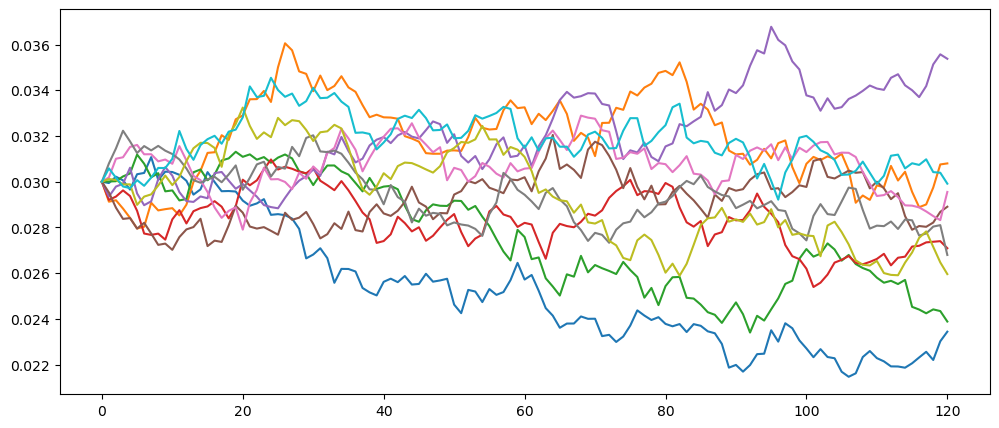

In [33]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5), legend=False)

In [35]:
import ipywidgets as widgets
from IPython.display import display

def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))
    
controls = widgets.interactive(show_cir,
                              r_0=(0,.15,.01),
                              a=(0,1,.1),
                              b=(0,.15,.01),
                              sigma=(0,.1,.01),
                              n_scenarios=(1,100, 1))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the 
generated interestrate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T) =\left({\frac {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$

and 

$$ B(t,T) ={\frac {2(e^{\tau h}-1)}{2h+(a+h)(e^{tau h}-1)}} $$

and

$$ h={\sqrt {a^{2}+2\sigma ^{2}}} $$

and

$$ \tau = T-t $$

In [39]:
import math

def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year)+1 # Because n_years might be a float
    
    dwt = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios)) # size=(#rows, #columns)
    rates = np.empty_like(dwt)
    rates[0] = r_0
    
    # For price generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(dwt)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ###
                          
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*dwt[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well...
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices

In [41]:
# show_cir_prices with controls

def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))
controls = widgets.interactive(show_cir_prices,
                              r_0=(0,.15,.01),
                              a=(0,1,.1),
                              b=(0,.15,.01),
                              sigma=(0,.1,.01),
                              n_scenarios=(1,100, 1))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [45]:
a_0 = 0.75 # asset value(millions)
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, r=0.03) #45:12
n_bonds_ican_buy = a_0/zc_0
av_zc_bonds = n_bonds_ican_buy*bond_prices
av_cash = a_0*(rates/12+1).cumprod()


<AxesSubplot:>

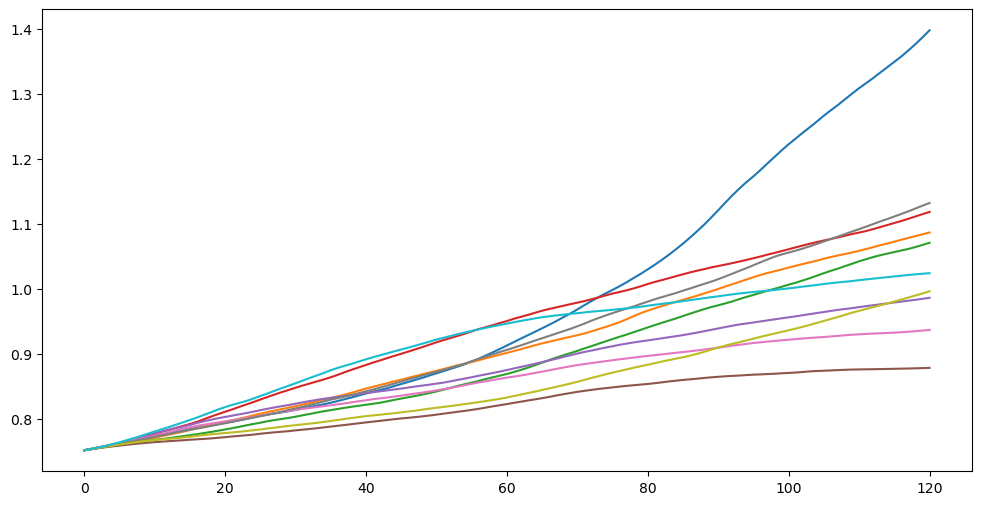

In [46]:
av_cash.plot(legend=False, figsize=(12,6))

<AxesSubplot:>

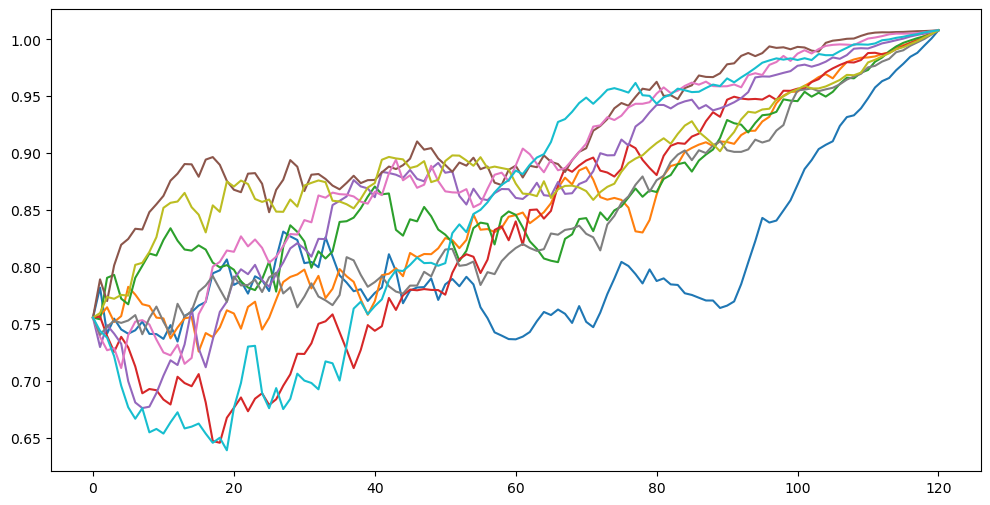

In [47]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash(10 scenarios)'}>

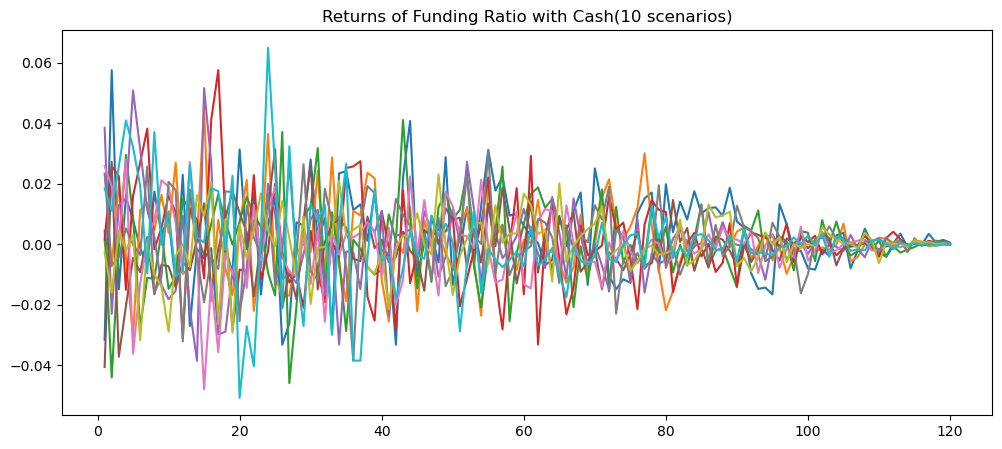

In [48]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash(10 scenarios)', legend=False, figsize=(12,5))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash(10 scenarios)'}>

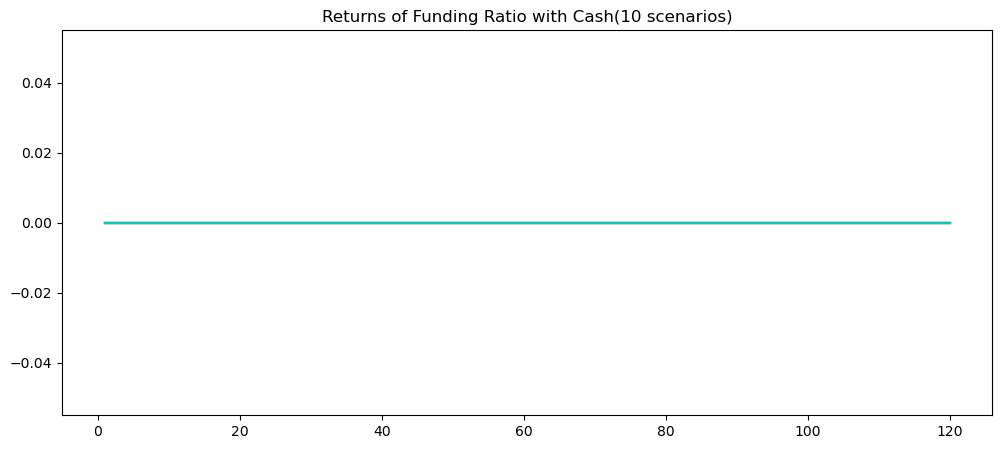

In [49]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash(10 scenarios)', legend=False, figsize=(12,5))

# STEADY FUNDING RATIO !!! THIS IS WHAT YOU WANT

In [63]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:>

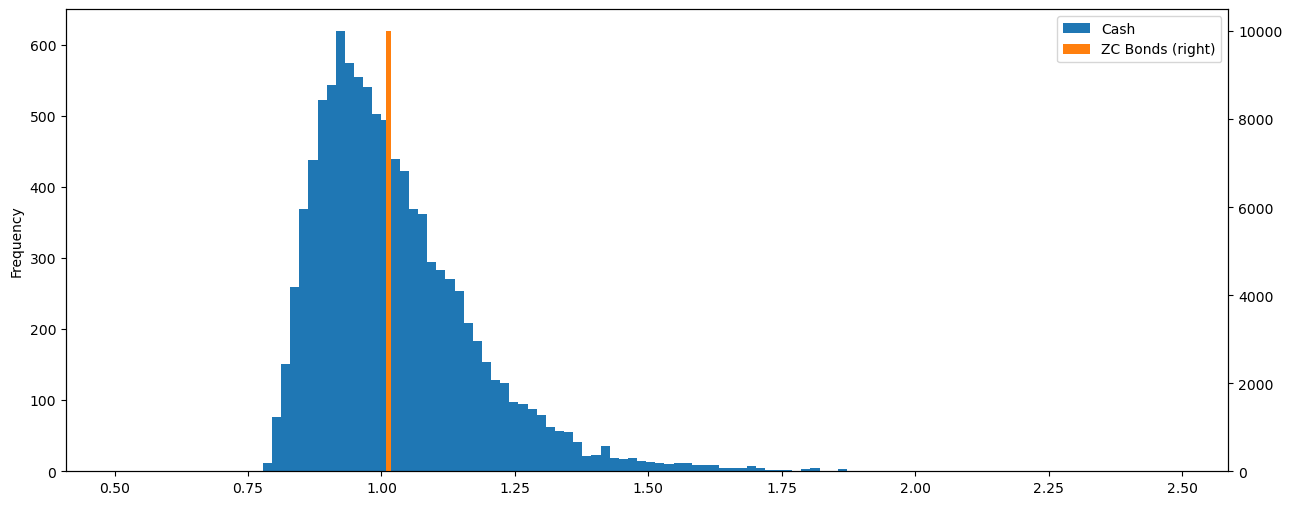

In [64]:
terminal__fr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
terminal_fr_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = terminal__fr_cash.plot.hist(label="Cash", figsize=(15,6), bins=100, legend=True)
terminal_fr_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True)